# Soma Detection Analysis of Whole-Brain Light-Sheet Images

## 1. Before Using this notebook

### 1a. Install brainlit, and other packages that this notebook uses
### 1b. Write images to s3 using CloudReg
    - e.g. python -m cloudreg.scripts.create_precomputed_volumes --s3_input_paths /mnt/NAS/SmartSPIM_Data/2022_03_02/20220302_14_40_04_8529_destriped_DONE/Ex_561_Em_600_stitched --s3_output_paths  s3://smartspim-precomputed-volumes/2022_03_02/8529/Ch_561_v2  --voxel_size 1.83 1.83 2 --num_procs 24 --resample_iso False
### 1c. Make point annotations in neuroglancer to identify subvolumes for validation (and possible training)
    - instructions: https://neurodata.io/help/neuroglancer-pt-annotations/
    ,
    {
    "type":"pointAnnotation",
    "name": "soma_val",
    "points": []
    },
    {
    "type":"pointAnnotation",
    "name": "nonsoma_val",
    "points":[]
    }
### 1d. Update soma_data.py file

### \* Inputs \*

In [10]:
from brainlit.preprocessing import removeSmallCCs
from brainlit.BrainLine.data.soma_data import brain2paths, brain2centers
from brainlit.BrainLine.analyze_results import SomaDistribution
from brainlit.BrainLine.util import (
    json_to_points,
    find_atlas_level_label,
    fold,
    setup_atlas_graph,
    get_atlas_level_nodes,
    download_subvolumes
)
from brainlit.BrainLine.apply_ilastik import ApplyIlastik, ApplyIlastik_LargeImage
from brainlit.BrainLine.parse_ara import *
import xml.etree.ElementTree as ET
from cloudreg.scripts.transform_points import NGLink
from brainlit.BrainLine.imports import *

%gui qt5

In [11]:
brainlit_path = Path(os.path.abspath(""))
brainlit_path = brainlit_path.parents[3]
print(f"Path to brainlit: {brainlit_path}")

for id in brain2paths.keys():
    if "base" in brain2paths[id].keys() and "val_info" in brain2paths[id].keys():
        base = brain2paths[id]["base"]
        if "http" in base:
            print(f"Sample {id}: http in basepath, which may cause write errors")

        try:
            url = brain2paths[id]["val_info"]["url"]
            layer = brain2paths[id]["val_info"]["somas_layer"]
            pts = json_to_points(url)[layer]
            layer = brain2paths[id]["val_info"]["nonsomas_layer"]
            pts = json_to_points(url)[layer]
        except:
            print(f"Sample {id}: Error finding validation annotations with val_info")

        if "train_info" in brain2paths[id].keys():
            try:
                url = brain2paths[id]["train_info"]["url"]
                layer = brain2paths[id]["train_info"]["somas_layer"]
                pts = json_to_points(url)[layer]
                layer = brain2paths[id]["train_info"]["nonsomas_layer"]
                pts = json_to_points(url)[layer]
            except:
                print(f"Sample {id}: Error finding training annotations with train_info")
    else:
        print(f"Sample {id}: Does not conform to desired format")

Path to brainlit: /Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit
Sample atlas: Does not conform to desired format
Sample 8557: Error finding validation annotations with val_info
Sample 8555: Error finding validation annotations with val_info
Sample 8607: Error finding validation annotations with val_info
Sample 8468: Error finding validation annotations with val_info
Sample 8606: Error finding validation annotations with val_info


## 2. Download benchmark data

### \*Inputs\*

In [12]:
brain = "887"  # brain ID
soma_data_dir = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/"  # path to directory where training/validation data should be stored
dataset_to_save = "val"  # train or val

antibody_layer = "Ch_647"
background_layer = "Ch_561"
endogenous_layer = "Ch_488"

### Setup paths

In [13]:
layer_names = [antibody_layer, background_layer, endogenous_layer]

if brain not in brain2paths.keys():
    raise ValueError(f"brain {brain} not an entry in brain2paths in axon_data.py file")

if f"{dataset_to_save}_info" not in brain2paths[
    brain
].keys() or dataset_to_save not in ["train", "val"]:
    raise ValueError(f"{dataset_to_save}_info not in brain2paths[{brain}].keys()")


for layer in [antibody_layer, background_layer, endogenous_layer]:
    try:
        CloudVolume(base + layer)
    except:
        print(f"Sample {id}: Layer {layer} not found in {base}")

### Download data

In [15]:
download_subvolumes(soma_data_dir, brain_id = brain, layer_names = layer_names, dataset_to_save = dataset_to_save, object_type="soma")

fg shape: (7426, 8806, 3900, 1) at [1830. 1830. 2000.]
bg shape: (7426, 8806, 3900, 1) at [1830. 1830. 2000.]
endo shape: (7426, 8806, 3900, 1) at [1830. 1830. 2000.]
[10, 10] centers
Downloaded data will be stored in /Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma//brain887/val/


Saving positive samples: 100%|██████████| 10/10 [03:01<00:00, 18.13s/it]


## 3. View downloaded data (optional)

### \*Inputs\*

In [ ]:


fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/brainr2/val/891_4202_1717_pos.h5"  # path to file for viewing
scale = [1.8, 1.8, 2]  # voxel size in microns

In [ ]:
with h5py.File(fname, "r") as f:
    pred = f.get("image_3channel")
    image_fg = pred[0, :, :, :]
    image_bg = pred[1, :, :, :]
    image_endo = pred[2, :, :, :]

viewer = napari.Viewer(ndisplay=3)
viewer.add_image(image_fg, scale=scale)
viewer.add_image(image_bg, scale=scale)
viewer.add_image(image_endo, scale=scale)
viewer.scale_bar.visible = True
viewer.scale_bar.unit = "um"

## 4. Apply ilastik to validation data

You can do this programmatically (below), or you can use the ilastik GUI (which is sometimes faster)

### \* Inputs \*

In [2]:
model = "_rabies_pix_3ch"
project_path = f"/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/matt_soma{model}.ilp"  # path to ilastik model to be used
ilastik_path = "/Applications/ilastik-1.4.0b21-OSX.app/Contents/ilastik-release/run_ilastik.sh"
brains_path = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/"
brains_path = "/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/"
brains = ["test"]#[brain]

In [3]:
applyilastik = ApplyIlastik(ilastk_path = ilastik_path, project_path = project_path, brains_path = brains_path, brains = brains)
applyilastik.process_somas()
applyilastik.move_results()

### \*Inputs (if relevant)\*
- identify files that have two somas in variable below. Since voxel coordinates are likely to be unique across samples, the file names below do not include sample IDs.

In [ ]:
doubles = [
    "3972_1636_1575_pos_Probabilities.h5",
    "2867_4336_1296_pos_Probabilities.h5",
    "2607_1845_1309_pos_Probabilities.h5",
    "2101_3397_1747_pos_Probabilities.h5",
    "2011_3452_1911_pos_Probabilities.h5",
    "2113_3353_1727_pos_Probabilities.h5",
    "1968_3472_?1784_pos_Probabilities.h5",
]  # 8446

## 5. Check Results

### Validation

In [ ]:
recalls = []
precisions = []

files_dir = f"/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/brain{brain}/val/"
onlyfiles = [
    f for f in os.listdir(files_dir) if os.path.isfile(os.path.join(files_dir, f))
]
test_files = [f for f in onlyfiles if "Probabilities" in f]  # "probabilities"
print(test_files)

size_thresh = 500

thresholds = list(np.arange(0.0, 1.0, 0.02))

for threshold in thresholds:
    tot_pos = 0
    tot_neg = 0
    true_pos = 0
    false_pos = 0
    for filename in tqdm(test_files, disable=True):
        if filename in doubles:
            newpos = 2
        else:
            newpos = 1

        fname = files_dir + filename
        f = h5py.File(fname, "r")
        pred = f.get("exported_data")
        pred = pred[0, :, :, :]
        mask = pred > threshold
        labels = measure.label(mask)
        props = measure.regionprops(labels)

        if "pos" in filename:
            num_detected = 0
            tot_pos += newpos
            for prop in props:
                if prop["area"] > size_thresh:
                    if num_detected < newpos:
                        true_pos += 1
                        num_detected += 1
                    else:
                        false_pos += 1
        elif "neg" in filename:
            tot_neg += 1
            for prop in props:
                if prop["area"] > size_thresh:
                    false_pos += 1

    recall = true_pos / tot_pos
    recalls.append(recall)
    if true_pos + false_pos == 0:
        precision = 0
    else:
        precision = true_pos / (true_pos + false_pos)
    precisions.append(precision)
    if precision == 0 and recall == 0:
        fscore = 0
    else:
        fscore = 2 * precision * recall / (precision + recall)
    print(
        f"threshold: {threshold}: precision: {precision}, recall: {recall}, f-score: {fscore} for {tot_pos} positive samples in {len(test_files)} images"
    )

fscores = [
    2 * precision * recall / (precision + recall)
    if (precision != 0 and recall != 0)
    else 0
    for precision, recall in zip(precisions, recalls)
]
dict = {
    "Recall": recalls,
    "Precision": precisions,
    "F-score": fscores,
    "Threshold": thresholds,
}
df = pd.DataFrame(dict)
max_fscore = df["F-score"].max()
best_threshold = float(df.loc[df["F-score"] == max_fscore]["Threshold"].iloc[0])
best_rec = float(df.loc[df["F-score"] == max_fscore]["Recall"].iloc[0])
best_prec = float(df.loc[df["F-score"] == max_fscore]["Precision"].iloc[0])
sns.set(font_scale=2)

plt.figure(figsize=(8, 8))
sns.lineplot(data=df, x="Recall", y="Precision", estimator=np.amax, ci=False)
plt.scatter(
    best_rec,
    best_prec,
    c="r",
    label=f"Max f-score: {max_fscore:.2f} thresh:{best_threshold:.2f}",
)
plt.xlim([0, 1.1])
plt.ylim([0, 1.1])
plt.title(f"Brain {brain} Validation: {tot_pos}+ {tot_neg}-")
plt.legend()

### If results above are not adequate, improve model and try again

In my case, I identify more subvolumes from the sample at hand using the same process as for validation data, and add it as training data to the model and retrain.

### Examine best threshold

In [ ]:
for filename in tqdm(test_files, disable=True):
    print(f"*************File: {filename}*********")
    if filename in doubles:
        newpos = 2
    else:
        newpos = 1

    im_fname = files_dir + filename[:-17] + ".h5"
    fname = files_dir + filename
    f = h5py.File(fname, "r")
    pred = f.get("exported_data")
    pred = pred[0, :, :, :]
    mask = pred > best_threshold
    labels = measure.label(mask)
    props = measure.regionprops(labels)

    if "pos" in filename:
        num_detected = 0
        tot_pos += newpos
        for prop in props:
            area = prop["area"]
            if area > size_thresh:
                print(f"area of detected object: {area}")
                if num_detected < newpos:
                    true_pos += 1
                    num_detected += 1
                else:
                    print(f"Soma false positive Area: {area}")
                    f = h5py.File(im_fname, "r")
                    im = f.get("image_3channel")
                    viewer = napari.Viewer(ndisplay=3)
                    viewer.add_image(im[0, :, :, :], name=filename)
                    viewer.add_image(im[1, :, :, :], name="bg")
                    viewer.add_image(im[2, :, :, :], name="endo")
                    viewer.add_labels(mask)
                    viewer.add_labels(
                        labels == prop["label"],
                        name=f"soma false positive area: {area}",
                    )
                    false_pos += 1
        if num_detected == 0:
            print(f"Soma false negative")
            f = h5py.File(im_fname, "r")
            im = f.get("image_3channel")
            viewer = napari.Viewer(ndisplay=3)
            viewer.add_image(im[0, :, :, :], name=filename)
            viewer.add_image(im[1, :, :, :], name="bg")
            viewer.add_image(im[2, :, :, :], name="endo")
            viewer.add_labels(mask, name="Soma false negative")
    elif "neg" in filename:
        for prop in props:
            area = prop["area"]
            if area > size_thresh:
                print(f"Nonsoma false positive Area: {area}")
                f = h5py.File(im_fname, "r")
                im = f.get("image_3channel")
                viewer = napari.Viewer(ndisplay=3)
                viewer.add_image(im[0, :, :, :], name=filename)
                viewer.add_image(im[1, :, :, :], name="bg")
                viewer.add_image(im[2, :, :, :], name="endo")
                viewer.add_labels(mask)
                viewer.add_labels(
                    labels == prop["label"], name=f"nonsoma false positive area: {area}"
                )
                false_pos += 1

### Paper figure for all validation

In [ ]:
brains = [
    "8607",
    "8606",
    "8477",
    "8531",
    "8608",
    "8529",
    "8557",
    "8555",
    "8446",
    "8454",
    "887",
]

recalls = []
precisions = []
brain_ids = []

best_precisions = []
best_recalls = []
best_fscores = {}

for brain_id in tqdm(brains, desc="Computing validation..."):
    if brain_id == "8557":
        brain_name = "r1"
    elif brain_id == "8555":
        brain_name = "r2"
    else:
        brain_name = brain_id

    files_dir = f"/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/brain{brain_name}/val/"
    onlyfiles = [
        f for f in os.listdir(files_dir) if os.path.isfile(os.path.join(files_dir, f))
    ]
    test_files = [f for f in onlyfiles if "Probabilities" in f]

    best_fscore = 0

    size_thresh = 500

    thresholds = list(np.arange(0.0, 1.0, 0.02))

    for threshold in thresholds:
        tot_pos = 0
        true_pos = 0
        false_pos = 0
        for filename in tqdm(test_files, disable=True):
            if filename in doubles:
                newpos = 2
            else:
                newpos = 1

            fname = files_dir + filename
            f = h5py.File(fname, "r")
            pred = f.get("exported_data")
            pred = pred[0, :, :, :]
            mask = pred > threshold
            labels = measure.label(mask)
            props = measure.regionprops(labels)

            if "pos" in filename:
                num_detected = 0
                tot_pos += newpos
                for prop in props:
                    if prop["area"] > size_thresh:
                        if num_detected < newpos:
                            true_pos += 1
                            num_detected += 1
                        else:
                            false_pos += 1
            elif "neg" in filename:
                for prop in props:
                    if prop["area"] > size_thresh:
                        false_pos += 1

        recall = true_pos / tot_pos
        recalls.append(recall)
        if true_pos + false_pos == 0:
            precision = 1
        else:
            precision = true_pos / (true_pos + false_pos)

        precisions.append(precision)
        if precision == 0 and recall == 0:
            fscore = 0
        else:
            fscore = 2 * precision * recall / (precision + recall)

        if fscore > best_fscore:
            best_fscore = fscore
            best_prec = precision
            best_recall = recall

        brain_ids.append(brain_id)
    best_fscores[brain_id] = best_fscore
    best_precisions.append(best_prec)
    best_recalls.append(best_recall)


for i, brain_id in enumerate(brain_ids):
    brain_ids[i] = brain_id + f" - Max F-score: {best_fscores[brain_id]:.2f}"

data = {"Sample": brain_ids, "Recall": recalls, "Precision": precisions}
df = pd.DataFrame(data=data)

sns.set(rc={"figure.figsize": (10, 7)})
sns.set(font_scale=2)
sns.lineplot(data=df, x="Recall", y="Precision", hue="Sample", estimator="max", ci=None)
sns.scatterplot(x=best_recalls, y=best_precisions)

## 6. Make Annotation layers

### Transformed layers

In [11]:
atlas_vol = CloudVolume(
    "precomputed://https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_10um/annotation_10um_2017"
)
for layer in [
    antibody_layer,
    background_layer,
]:  # axon_mask is transformed into an image because nearest interpolation doesnt work well after downsampling
    layer_path = brain2paths[brain]["base"] + layer + "_transformed"
    info = CloudVolume.create_new_info(
        num_channels=1,
        layer_type="image",
        data_type="uint16",  # Channel images might be 'uint8'
        encoding="raw",  # raw, jpeg, compressed_segmentation, fpzip, kempressed
        resolution=atlas_vol.resolution,  # Voxel scaling, units are in nanometers
        voxel_offset=atlas_vol.voxel_offset,
        chunk_size=[32, 32, 32],  # units are voxels
        volume_size=atlas_vol.volume_size,  # e.g. a cubic millimeter dataset
    )
    vol_mask = CloudVolume(layer_path, info=info)
    vol_mask.commit_info()

## 7. Apply ilastik to whole image

### \* Inputs \*
You can use the notebook code below or the script using `soma_detect_image.py`

In [2]:
brain = "test"
antibody_layer = "antibody"
background_layer = "background"
endogenous_layer = "endogenous"

threshold = 0.28  # threshold to use for ilastik
data_dir = "/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainr_temp/" # "/data/tathey1/matt_wright/brainr_temp/"  # directory to store temporary subvolumes for segmentation
results_dir = "/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainr_results/"  # directory to store coordinates of soma detections

# Ilastik will run in "headless mode", and the following paths are needed to do so:
ilastik_path = "/Applications/ilastik-1.4.0b21-OSX.app/Contents/ilastik-release/run_ilastik.sh" #"/data/tathey1/matt_wright/ilastik/ilastik-1.4.0rc5-Linux/run_ilastik.sh"  # path to ilastik executable
ilastik_project = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/matt_soma_rabies_pix_3ch.ilp" #"/data/tathey1/matt_wright/ilastik/soma_model/matt_soma_rabies_pix_3ch.ilp"  # path to ilastik project

max_coords = [3072, 4352, 1792] #-1 if you want to process the whole dimension
ncpu = 1 #16  # number of cores to use for detection
chunk_size = [256, 256, 256]#[256, 256, 300]

In [3]:
layer_names=[antibody_layer, background_layer, endogenous_layer]

ilastik_largeimage = ApplyIlastik_LargeImage(ilastik_path = ilastik_path, ilastik_project=ilastik_project, results_dir=results_dir, ncpu=1)
ilastik_largeimage.apply_ilastik_parallel(brain_id=brain, layer_names=layer_names, threshold=threshold, data_dir=data_dir, chunk_size=chunk_size, max_coords=max_coords)
ilastik_largeimage.collect_results(brain_id="test")

reading files:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainr_results/all_somas_test.txt


/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainr_results/image_2816_4096_1536_somas.txt


reading files: 100%|██████████| 2/2 [00:00<00:00, 120.59it/s]


102 somas detected, first is: [2827.032345013477, 4151.219676549866, 1558.923180592992]
Writing /Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainr_results/all_somas_test.txt...
Viz link with detections: https://viz.neurodata.io/?json_url=https://json.neurodata.io/v1?NGStateID=UAFXAZDqNVc4OA


## 8. Register volume and transform data to atlas space using CloudReg

### 8a. You need to find an initial affine alignment using cloudreg.scripts.registration.get_affine_matrix. For example: 

A link to the ARA parcellation is:

`precomputed://https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_10um/annotation_10um_2017`

And some python commands to help with affine alignment is:

```
from cloudreg.scripts.registration import get_affine_matrix
get_affine_matrix([1,1,1], [15,0,0], "PIR", "RAI", 1.15, "precomputed://https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_10um/annotation_10um_2017")
```

### 8b. Run registration using cloudreg.scripts.registration. For example:

```
python -m cloudreg.scripts.registration -input_s3_path precomputed://s3://smartspim-precomputed-volumes/2023_01_20/MPRRabies/Ch_561 --output_s3_path precomputed://s3://smartspim-precomputed-volumes/2023_01_20/MPRRabies/atlas_to_target --atlas_s3_path https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_50um/average_50um --parcellation_s3_path https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_10um/annotation_10um_2017 --atlas_orientation PIR -orientation RPI --rotation 0 0 0 --translation 0 0 0 --fixed_scale 1.07 -log_s3_path precomputed://s3://smartspim-precomputed-volumes/2023_01_20/MPRRabies/atlas_to_target --missing_data_correction True --grid_correction False --bias_correction True --regularization 5000.0 --iterations 3000 --registration_resolution 100
```

### 8c. Transform data to atlas space using CloudReg

### Soma coordinates

```
python -m cloudreg.scripts.transform_points --target_viz_link https://viz.neurodata.io/?json_url=https://json.neurodata.io/v1?NGStateID=6ti276yAxXF_Rw --atlas_viz_link https://ara.viz.neurodata.io/?json_url=https://json.neurodata.io/v1?NGStateID=HvyNDGaPsd1wyg --affine_path /mnt/NAS/Neuroglancer\ Data/  --velocity_path /mnt/NAS/Neuroglancer\ Data/  --transformation_direction atlas
```

or

```
python -m cloudreg.scripts.transform_points --target_viz_link https://viz.neurodata.io/?json_url=https://json.neurodata.io/v1?NGStateID=05Fhxt5VBT-_1A --atlas_viz_link https://ara.viz.neurodata.io/?json_url=https://json.neurodata.io/v1?NGStateID=HvyNDGaPsd1wyg --affine_path /cis/home/tathey/MPRRabies_Ch_561_registration/downloop_1_A.mat   --velocity_path /cis/home/tathey/MPRRabies_Ch_561_registration/downloop_1_v.mat  --transformation_direction atlas
```

This will produce a neuroglancer link with the transformed soma coordinates, which should be added to `soma_data.py` under the `somas_atlas_url` key. Then the code below, or `soma_brainrender.py`, can be used to visualize the data.

### Image

```
python -m cloudreg.scripts.transform_data --target_layer_source precomputed://s3://smartspim-precomputed-volumes/2022_09_20/887/Ch_647 --transformed_layer_source precomputed://s3://smartspim-precomputed-volumes/2022_09_20/887/Ch_647_transformed --affine_path /cis/home/tathey/887_Ch_561_registration/downloop_1_A.mat  --velocity_path /cis/home/tathey/887_Ch_561_registration/downloop_1_v.mat
```

## 9. View coronal maps

### \*Inputs\*

In [4]:
# colors = {
#     "tph2 vglut3": "blue",
#     "tph2 gad2": "red",
#     "gad2 vgat": "green",
# }  # colors for different genotypes
colors = {
    "test": "blue",
}  # colors for different genotypes
symbols = ["o", "+", "^", "vbar"]
brain_ids = ["test"]
fold_on = True


In [5]:
sd = SomaDistribution(brain_ids = brain_ids)
sd.napari_coronal_section(z=1000, subtype_colors = colors, symbols = symbols, fold_on = fold_on)

Brain test: Collecting atlas space soma points from layer: transformed_points


Processing brains in z=1000: 100%|██████████| 1/1 [00:00<00:00, 11.83it/s]


## 10. Display bar charts

Brain test: Collecting atlas space soma points from layer: transformed_points
Populating: Cerebral cortex
Populating: Olfactory areas
Populating: Hippocampal formation
Populating: Striatum
Populating: Bed nuclei of the stria terminalis
Populating: Hypothalamus
Populating: Thalamus
Populating: Lateral habenula
Populating: Cerebellar nuclei
Populating: Midbrain
Populating: Hindbrain
Populating: Amygdalar Nuclei


/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/brainlit/BrainLine/analyze_results.py:208: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  bplot.set_xscale("log")


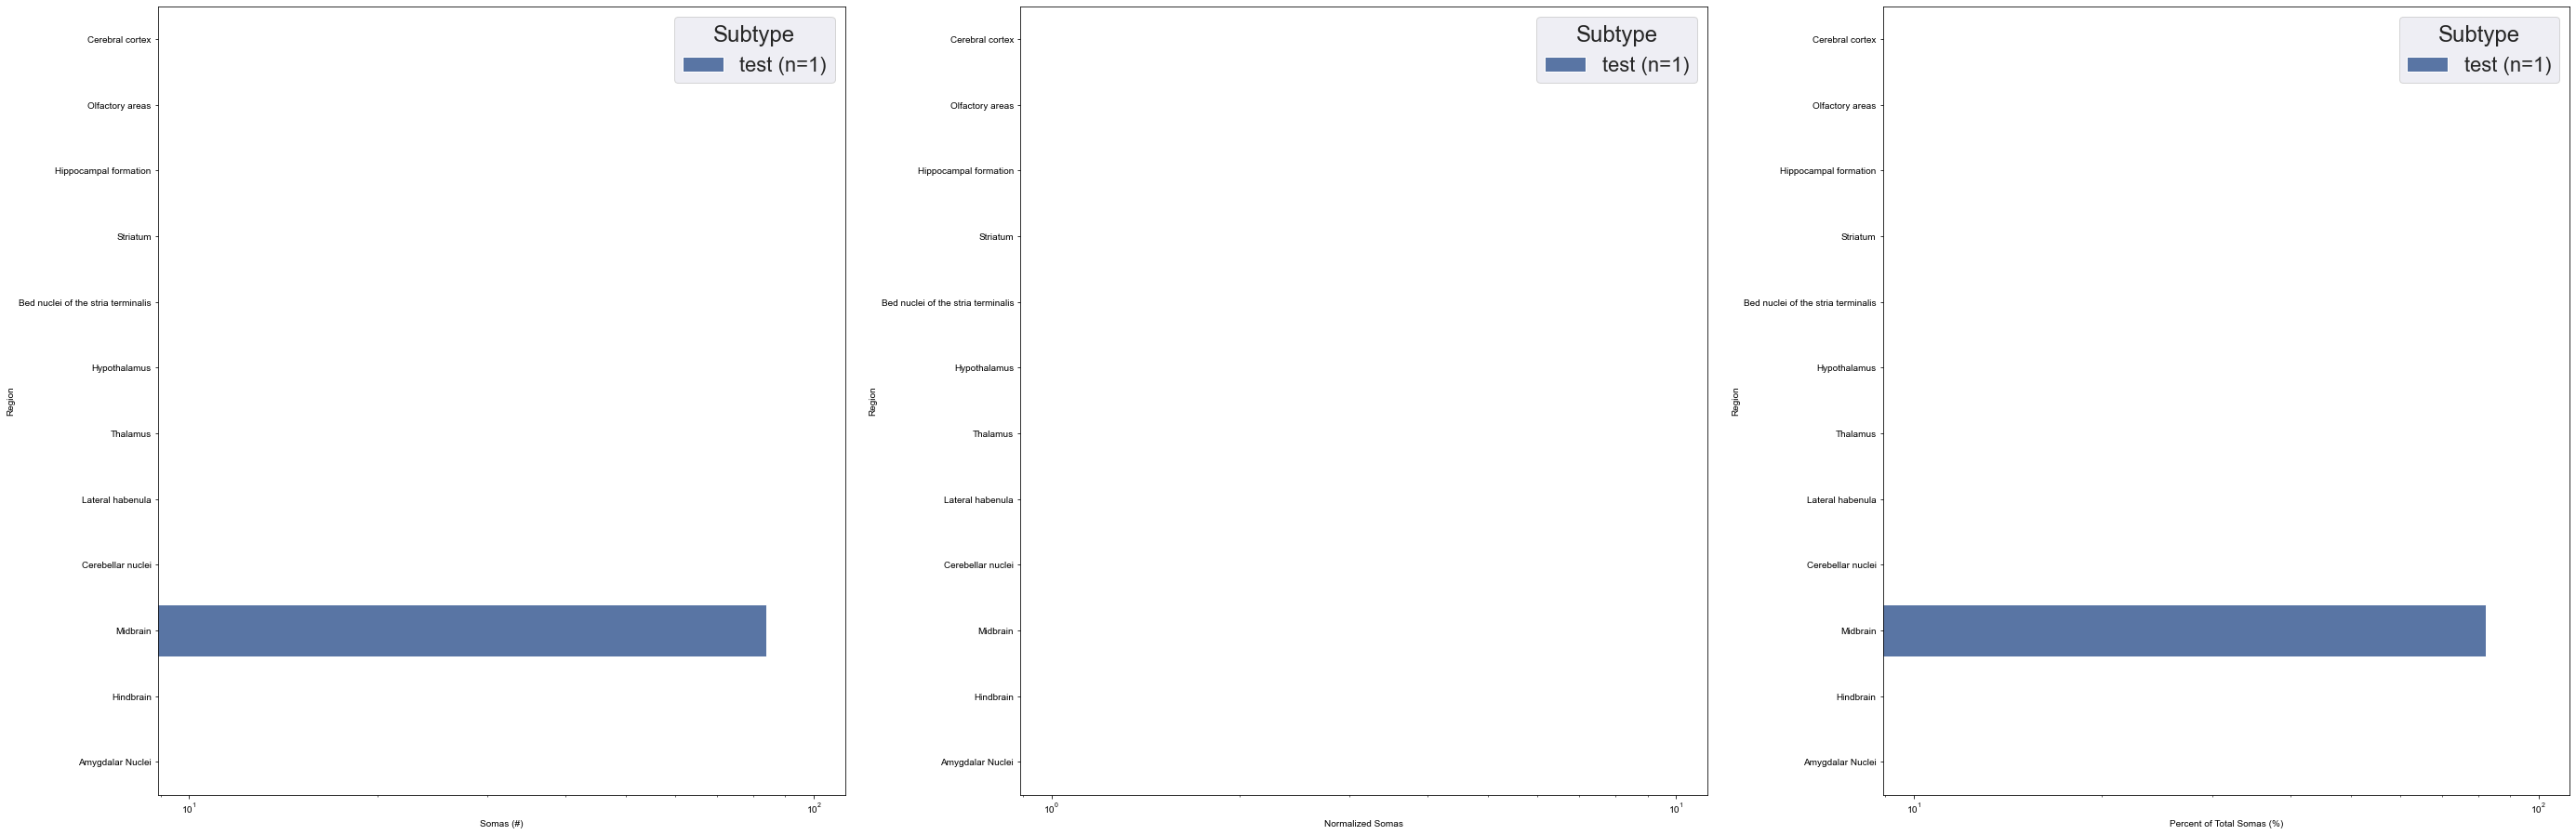

In [2]:
regions = [
    688,  # cerebral cortex
    698,  # olfactory areas
    1089,  # hippocampal formation
    # 583, # claustrum
    477,  # striatum
    # 803, # pallidum
    351,  # bed nuclei of stria terminalis
    # 703, #cortical subplate
    1097,  # hypothalamus
    549,  # thalamus
    186,  # lateral habenula
    519,  # cerebellar nuclei
    313,  # midbrain
    1065,  # hindbrain
]  # allen atlas region IDs to be shown
# see: https://connectivity.brain-map.org/projection/experiment/480074702?imageId=480075280&initImage=TWO_PHOTON&x=17028&y=11704&z=3

composite_regions = {
    "Amygdalar Nuclei": [131, 295, 319, 780]
}  # Custom composite allen regions where key is region name and value is list of allen regions

brain_ids = ["test"]
sd = SomaDistribution(brain_ids = brain_ids)
sd.region_barchart(regions, composite_regions=composite_regions, normalize_region=872)


### \*Inputs\*

In [10]:
wholebrain_results_dir = ""  #

brains = {
    "8557": "tph2 vglut3",
    "8555": "tph2 vglut3",
    "8607": "tph2 gad2",
    "8606": "tph2 gad2",
    "8477": "gad2/vgat",
    "8531": "gad2/vgat",
    "8608": "tph2 gad2",
    "8529": "gad2/vgat",
    "8454": "gad2/vgat",
    "8446": "gad2/vgat",
    "MPRRabies": "tph2 gad2",
}  # dictionary with key as sample ID and value as subtype for results to be shown

regions = [
    688,  # cerebral cortex
    698,  # olfactory areas
    1089,  # hippocampal formation
    # 583, # claustrum
    477,  # striatum
    # 803, # pallidum
    351,  # bed nuclei of stria terminalis
    # 703, #cortical subplate
    1097,  # hypothalamus
    549,  # thalamus
    186,  # lateral habenula
    519,  # cerebellar nuclei
    313,  # midbrain
    1065,  # hindbrain
]  # allen atlas region IDs to be shown
# see: https://connectivity.brain-map.org/projection/experiment/480074702?imageId=480075280&initImage=TWO_PHOTON&x=17028&y=11704&z=3

composite_regions = {
    "Amygdalar Nuclei": [131, 295, 319, 780]
}  # Custom composite allen regions where key is region name and value is list of allen regions


level = "coarse"  # coarse or fine, dictates whether the regions specified above will be shown (coarse), or their subregions (fine)

if level not in ["coarse", "fine"]:
    raise ValueError(f"level must be coarse or fine, not {level}")

### Setup data

In [ ]:
counts = {}
for gene in set(brains.values()):
    count = 0
    for brain in brains.keys():
        if brains[brain] == gene:
            count += 1
    counts[gene] = count


quantification_dicts = {}

for brain in brains.keys():
    path = (
        "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/wholebrain_results/quantification_dict_"
        + brain
        + ".pickle"
    )
    with open(path, "rb") as f:
        quantification_dict = pickle.load(f)

    quantification_dicts[brain] = quantification_dict

In [ ]:
G = setup_atlas_graph()
max_level = 0

for node in G.nodes:
    if G.nodes[node]["level"] > max_level:
        max_level = G.nodes[node]["level"]
    for brain in quantification_dicts.keys():
        G.nodes[node][brain] = 0

In [ ]:
# add data
i_test = 0
print(f"Max level: {max_level}")
print(G.nodes[997][list(quantification_dicts.keys())[i_test]])
for brain, quantification_dict in quantification_dicts.items():
    for key in quantification_dict.keys():
        if key in G.nodes:
            G.nodes[key][brain] = G.nodes[key][brain] + quantification_dict[key]

print(G.nodes[997][list(quantification_dicts.keys())[i_test]])

# add child data to parent data
for brain in quantification_dicts.keys():
    for lvl in range(max_level, 0, -1):
        for node in G.nodes:
            if G.nodes[node]["level"] == lvl:
                parent = list(G.in_edges(node))[0][0]
                G.nodes[parent][brain] = G.nodes[parent][brain] + G.nodes[node][brain]
print(G.nodes[997][list(quantification_dicts.keys())[i_test]])

In [ ]:
totals = {}

for brain in quantification_dicts.keys():
    total = 0
    for node in G.nodes:
        total += G.nodes[node][brain]
    totals[brain] = total

somas = []
somas_norm = []
somas_pct = []
gene = []
subregion_name = []
region_name = []
brain_ids = []
for region in regions:
    print(f"Populating: " + G.nodes[region]["name"])
    # choose level here
    if level == "fine":
        children = list(G.successors(region))
    elif level == "coarse":
        children = [region]
    else:
        raise ValueError(f"level must be coarse or fine, not {level}")

    for child in children:
        for brain in quantification_dicts.keys():
            soma_count = G.nodes[child][brain]
            drn_somas = G.nodes[872][brain]

            somas.append(soma_count)
            if drn_somas != 0:
                somas_norm.append(soma_count / drn_somas)
            else:
                print(f"Warning: brain {brain} has no inputs from DRN")
                somas_norm.append(0)
            somas_pct.append(G.nodes[child][brain] / totals[brain] * 100)

            gene.append(brains[brain] + f" (n={counts[brains[brain]]})")
            subregion_name.append(G.nodes[child]["name"])
            region_name.append(G.nodes[region]["name"])
            brain_ids.append(brain)

for region_component_name in composite_regions.keys():
    print(f"Populating: " + region_component_name)
    region_components = composite_regions[region_component_name]
    for brain in quantification_dicts.keys():
        soma_count = 0

        for region_component in region_components:
            soma_count += G.nodes[region_component][brain]

        drn_somas = G.nodes[872][brain]

        somas.append(soma_count)
        if drn_somas != 0:
            somas_norm.append(soma_count / drn_somas)
        else:
            print(f"Warning: brain {brain} has no inputs from DRN")
            somas_norm.append(0)
        somas_pct.append(G.nodes[child][brain] / totals[brain] * 100)

        gene.append(brains[brain] + f" (n={counts[brains[brain]]})")
        subregion_name.append(region_component_name)
        region_name.append(region_component_name)
        brain_ids.append(brain)

d = {
    "Somas (#)": somas,
    "Normalized Somas": somas_norm,
    "Percent of Total Somas (%)": somas_pct,
    "Gene": gene,
    "Subregion": subregion_name,
    "Region": region_name,
    "Brain ID": brain_ids,
}
df = pd.DataFrame(data=d)

### Make bar chart

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(39, 13))
sns.set(font_scale=2)

test = "Mann-Whitney"
# test = "t-test_ind"
correction = "fdr_by"

# soma counts
fig_args = {
    "y": "Somas (#)",
    "x": "Subregion",
    "hue": "Gene",
    "data": df,
}
pairs = []
unq_subregions = []
for subregion in subregion_name:
    if subregion not in unq_subregions:
        unq_subregions.append(subregion)


genes = df["Gene"].unique()
gene_pairs = [(a, b) for idx, a in enumerate(genes) for b in genes[idx + 1 :]]

for gene_pair in gene_pairs:
    for subregion in unq_subregions:
        pairs.append(
            (
                (subregion, gene_pair[0]),
                (subregion, gene_pair[1]),
            )
        )


annotator = Annotator(axes[0], pairs, **fig_args)
fig_args = {
    "x": "Somas (#)",
    "y": "Subregion",
    "hue": "Gene",
    "data": df,
}


sns.set(font_scale=2)
bplot = sns.barplot(ax=axes[0], orient="h", **fig_args)
bplot.set_xscale("log")

annotator.configure(
    test=test, text_format="star", loc="outside", comparisons_correction=correction
)
annotator.new_plot(bplot, orient="h", plot="barplot", **fig_args)
annotator.apply_and_annotate()

# soma counts
fig_args = {
    "y": "Normalized Somas",
    "x": "Subregion",
    "hue": "Gene",
    "data": df,
}
pairs = []
unq_subregions = []
for subregion in subregion_name:
    if subregion not in unq_subregions:
        unq_subregions.append(subregion)


genes = df["Gene"].unique()
gene_pairs = [(a, b) for idx, a in enumerate(genes) for b in genes[idx + 1 :]]

for gene_pair in gene_pairs:
    for subregion in unq_subregions:
        pairs.append(
            (
                (subregion, gene_pair[0]),
                (subregion, gene_pair[1]),
            )
        )


annotator = Annotator(axes[1], pairs, **fig_args)
fig_args = {
    "x": "Normalized Somas",
    "y": "Subregion",
    "hue": "Gene",
    "data": df,
}


sns.set(font_scale=2)
bplot = sns.barplot(ax=axes[1], orient="h", **fig_args)
bplot.set_xscale("log")

annotator.configure(
    test=test, text_format="star", loc="outside", comparisons_correction=correction
)
annotator.new_plot(bplot, orient="h", plot="barplot", **fig_args)
annotator.apply_and_annotate()

# distribution
fig_args = {
    "y": "Percent of Total Somas (%)",
    "x": "Subregion",
    "hue": "Gene",
    "data": df,
}
pairs = []
unq_subregions = []
for subregion in subregion_name:
    if subregion not in unq_subregions:
        unq_subregions.append(subregion)


for gene_pair in gene_pairs:
    for subregion in unq_subregions:
        pairs.append(
            (
                (subregion, gene_pair[0]),
                (subregion, gene_pair[1]),
            )
        )


annotator = Annotator(axes[2], pairs, **fig_args)
fig_args = {
    "x": "Percent of Total Somas (%)",
    "y": "Subregion",
    "hue": "Gene",
    "data": df,
}

bplot = sns.barplot(ax=axes[2], orient="h", **fig_args)
bplot.set_xscale("log")

annotator.configure(
    test=test, text_format="star", loc="outside", comparisons_correction=correction
)
annotator.new_plot(bplot, orient="h", plot="barplot", **fig_args)
annotator.apply_and_annotate()

fig.tight_layout()

### Compare distributions with PCA

In [ ]:
X = []
brain_ids = []
genotypes = []

for i, brain in enumerate(brains):
    print(brain)
    region_order = list(df.loc[df["Brain ID"] == brain]["Region"])

    if i == 0:
        standard_region_order = region_order
    elif standard_region_order != region_order:
        raise ValueError(f"Different region order for brain {brain}")

    distrib = list(df.loc[df["Brain ID"] == brain]["Percent of Total Somas (%)"])
    X.append(distrib)

    brain_ids.append(brain)
    genotypes.append(brains[brain])

X = np.array(X)

pca = PCA(n_components=2)
X_2 = pca.fit_transform(X)

df_pca = {
    "PC 1": X_2[:, 0],
    "PC 2": X_2[:, 1],
    "Genotype": genotypes,
    "Brain ID": brain_ids,
}
df_pca = pd.DataFrame(data=df_pca)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(data=df_pca, x="PC 1", y="PC 2", hue="Genotype", ax=ax)


for i in range(df_pca.shape[0]):
    plt.text(
        x=df_pca["PC 1"][i] + 0.03,
        y=df_pca["PC 2"][i] + 0.03,
        s=df_pca["Brain ID"][i],
        fontdict=dict(color="black", size=20),
    )

plt.title(
    f"Input Distribution PCA with Explained Variance: {pca.explained_variance_ratio_}"
)

## Create local volume

In [21]:
vol = CloudVolume("precomputed://s3://smartspim-precomputed-volumes/2022_03_10/8531/Ch_647_iso")

In [22]:
subvol = vol[256*11:256*12,256*16:256*17, 256*6:256*7]

Downloading: 100%|██████████| 8/8 [00:25<00:00,  3.13s/it]


In [24]:
info = CloudVolume.create_new_info(
    num_channels=1,
    layer_type="image",
    data_type="uint16",  # Channel images might be 'uint8'
    encoding="raw",  # raw, jpeg, compressed_segmentation, fpzip, kempressed
    resolution=vol.resolution,  # Voxel scaling, units are in nanometers
    voxel_offset=vol.voxel_offset,
    chunk_size=vol.chunk_size,  # units are voxels
    volume_size=vol.volume_size,  # e.g. a cubic millimeter dataset
)

vol_ex = CloudVolume("precomputed://file:///Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/brainlit/BrainLine/data/example", info=info, compress=False)
vol_ex.commit_info()

In [25]:
vol_ex[256*11:256*12,256*16:256*17, 256*6:256*7] = subvol

Uploading: 100%|██████████| 8/8 [00:00<00:00, 28.43it/s]


In [15]:
256*7

1792

In [7]:
vol = CloudVolume("precomputed://file:///Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/brainlit/BrainLine/data/example/endogenous", fill_missing=True)